# ODS – Etapa 1 (Clasificación de texto)
El objetivo de este trabajo es clasificar opiniones ciudadanas en relación con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4 mediante modelos de aprendizaje supervisado.  
- **ODS 1:** Fin de la pobreza  
- **ODS 3:** Salud y bienestar  
- **ODS 4:** Educación de calidad  

Estructura:
1) Entendimiento de los datos
2) Procesamiento de datos
3) Modelos (vistos y no vistos en clase)
4) Ajuste de hiperparámetros
5) Modelo Final
6) Interpretación de resultados
7) Exportación de predicciones 

## 1. Entendimiento de Datos

### 1.1 Imports y configuración

En esta sección se cargan las librerías necesarias para el proyecto.  
- **pandas, numpy y matplotlib**: herramientas base para manipulación de datos y visualización.  
- **scikit-learn**: librería principal para machine learning, desde donde se importan módulos para:
  - **Preprocesamiento**: TfidfVectorizer para convertir textos en vectores numéricos.  
  - **Modelado**: KNeighborsClassifier, DecisionTreeClassifier, MultinomialNB.  
  - **Evaluación**: train_test_split, GridSearchCV, StratifiedKFold, métricas y visualización de la matriz de confusión.  
  - **Feature selection**: chi2 para selección estadística de variables.  
- **joblib**: para exportar el modelo final entrenado.  

Además, se establecen parámetros de estilo para las gráficas y se fija una semilla aleatoria `RANDOM_STATE = 42` con el fin de garantizar reproducibilidad de los resultados.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2
from joblib import dump

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Buena practica para reproducibilidad


### 1.2 Carga de datos

Los datos provienen de archivos en formato XLS:

Cada registro tiene dos columnas principales:  
- **textos**: la opinión ciudadana en lenguaje natural.  
- **labels**: la etiqueta correspondiente al ODS asociado (1 = Fin de la pobreza, 3 = Salud y bienestar, 4 = Educación de calidad).

Se realiza:  
1. Lectura de los archivos Excel.  
2. Selección de las columnas relevantes.  
3. Visualización de las primeras instancias para confirmar la correcta importación.


In [2]:
DATA_PATH   = "Datos_proyecto.xlsx"  
DATA_PATH_TEST = "Datos de prueba_proyecto.xlsx"        
TEXT_COL    = "textos"                       
LABEL_COL   = "labels"

xls = pd.ExcelFile(DATA_PATH)
print("Hojas:", xls.sheet_names)
df = pd.read_excel(DATA_PATH, sheet_name=xls.sheet_names[0])
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"textos", LABEL_COL:"labels"})
test_data= pd.read_excel(DATA_PATH_TEST)
df.head(10)

Hojas: ['Sheet1']


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


### 1.3 Entendimiento de los datos

En esta sección realizamos un perfilamiento rápido del dataset para validar su estructura y conocer el comportamiento básico de los textos y las etiquetas (ODS). En particular:

- **Estructura y tipos**: dimensiones del dataset, columnas y tipos de dato.
- **Longitud de textos**: cálculo del numero de palabras y caracteres por opinión; estadísticos descriptivos.
- **Distribuciones**: histogramas y boxplots para identificar sesgos y posibles outliers.
- **Etiquetas (ODS)**: conteos y proporciones por clase para detectar desbalance.

Este diagnóstico guía las decisiones de **preparación** (limpieza, normalización, vectorización) y **evaluación** (métricas y validación estratificada) en el modelado.


In [3]:
print("Dimensiones:", df.shape)
display(df.info())

Dimensiones: (2424, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None

In [4]:
# Longitud de textos
df["len_words"] = df["textos"].astype(str).str.split().str.len()
df["len_chars"] = df["textos"].astype(str).str.len()
df[["len_words","len_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
len_words,2424.0,107.924092,35.575349,41.0,81.0,102.0,129.00,260.0
len_chars,2424.0,683.223185,223.563695,303.0,513.0,647.0,809.25,1492.0


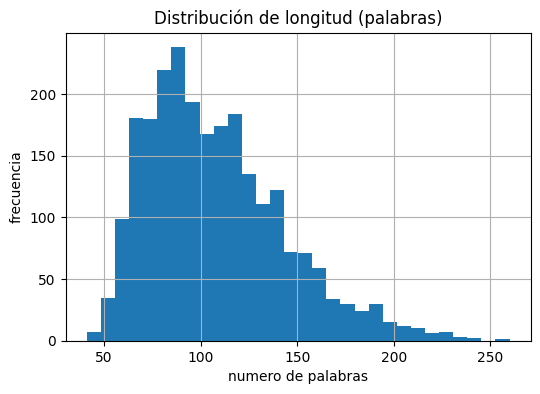

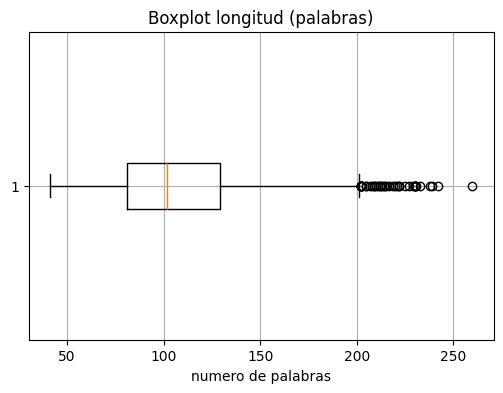

In [5]:
# Histograma longitudes (palabras)
fig, ax = plt.subplots()
ax.hist(df["len_words"], bins=30)
ax.set_title("Distribución de longitud (palabras)")
ax.set_xlabel("numero de palabras"); ax.set_ylabel("frecuencia")
plt.show()

# Boxplot para outliers
fig, ax = plt.subplots()
ax.boxplot(df["len_words"], vert=False)
ax.set_title("Boxplot longitud (palabras)")
ax.set_xlabel("numero de palabras")
plt.show()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

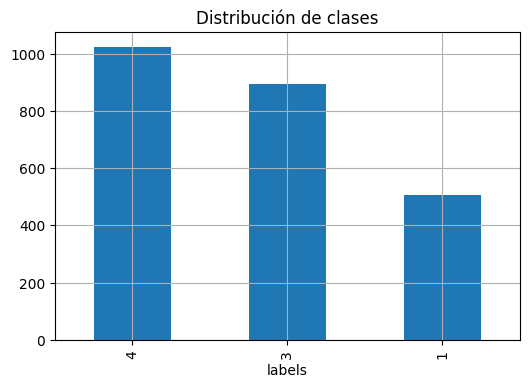

In [6]:
# Distribución de las clases
counts = df["labels"].value_counts()
counts.plot.bar(title="Distribución de clases")
counts

# Los resultados muestran que hay un desbalance en las clases, 
# se debe considerar hacer aumentación de datos con ia generativa (Es para entrega 2)

**Interpretacion del entendimiento de datos**

- Dataset con **2,424 registros** y **2 columnas** textos y labels, sin valores nulos.  
- Opiniones con longitud media de **108 palabras** y **683 caracteres**; se observan textos muy extensos pero no afectan el análisis inicial.  
- Distribución de etiquetas: ODS 4 = 1,025; ODS 3 = 894; ODS 1 = 505 → existe **desbalance moderado**, especialmente en ODS 1.  
- Decisiones: usar **stratify** en splits, evaluar con **F1-macro** y considerar balanceo en etapas posteriores.


### 1.4 Revisión Calidad de datos

Evaluamos 4 dimensiones prácticas para texto:
1) **Completitud**: NA, vacíos, mínimos de longitud.
2) **Unicidad**: duplicados por textos y por textos+labels.
3) **Validez/Consistencia**: esquema esperado y dominio de labels: 1,3,4.
4) **Ruido/Outliers**: textos extremadamente largos/cortos y señales de ruido.


In [7]:
# 1) Completitud
na = df.isna().sum()
empty = (df["textos"].astype(str).str.strip()=="").sum()

# 2) Unicidad
dup_text = df.duplicated(subset=["textos"]).sum()
dup_both = df.duplicated(subset=["textos","labels"]).sum()

# 3) Validez / Consistencia
cols_ok = set(df.columns) == {"textos","labels","len_words","len_chars"}
labels_ok = set(df["labels"].unique()) <= {1,3,4}

# 4) Ruido / Outliers
alpha = df["textos"].astype(str).apply(lambda s: sum(ch.isalpha() for ch in s)/max(1,len(s)))
pct_ruido = (alpha<0.6).mean()
p75, p95, pmax = df["len_words"].quantile([.75, .95, 1.0])
print(na, empty, dup_text, dup_both, cols_ok, labels_ok, pct_ruido, p75, p95, pmax)


textos       0
labels       0
len_words    0
len_chars    0
dtype: int64 0 0 0 True True 0.0 129.0 177.0 260.0


**Intepretación de la calidad de datos**

- **Completitud:** no se encontraron valores nulos ni textos vacíos; todos cumplen el mínimo de 3 palabras.  
- **Unicidad:** no hay duplicados ni por textos ni por textos+labels.  
- **Validez/Consistencia:** el esquema de columnas es el esperado y las etiquetas pertenecen al dominio correcto: 1, 3, 4.  
- **Ruido/Outliers:** 0% de textos con baja proporción alfabética; las longitudes muestran cola derecha con máximos de 260 palabras (esperables en opiniones extensas).  

En general, la base presenta alta calidad: completa, sin duplicados y con etiquetas válidas. Solo se documentan outliers largos, que no afectan el entrenamiento inicial.


## 2. Preparación de datos

Para entrenar modelos de clasificación de texto se realizaron tres pasos:

1. **Normalización y estandarización**: limpieza de caracteres, minúsculas, tokenización, eliminación de stopwords en español y stemming.  
2. **Split de datos**: división estratificada en entrenamiento, validación y prueba.  
3. **Vectorización TF-IDF**: transformación de textos a representaciones numéricas considerando unigramas y bigramas, con filtros de frecuencia mínima y máxima.


Las stopwords en español nos permiten eliminar palabras muy comunes (como “de”, “la”, “que”), que no aportan valor a la clasificación. De esta forma el modelo se concentra en términos más relevantes para diferenciar entre los ODS. Esto es coherente con el entendimiento previo, donde identificamos vocabulario repetitivo que podía introducir ruido.


In [8]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

spanish_stopwords = stopwords.words("spanish")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yarso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se aplica normalización (minúsculas, limpieza de caracteres) y stemming, junto con tokenización y eliminación de stopwords. Esto asegura que textos con la misma raíz (e.g. “educar”, “educación”) se procesen como equivalentes, reduciendo variabilidad innecesaria y facilitando que el modelo capture patrones claros.


In [9]:
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer

# Prepara herramientas
wpt = WordPunctTokenizer()
ps = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def normalize_text(doc):
    # Limpieza de caracteres
    doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    
    # Tokenización
    tokens = wpt.tokenize(doc)
    
    # Quitar stopwords + stemming
    filtered_tokens = [ps.stem(token) for token in tokens if token not in spanish_stopwords]
    
    return ' '.join(filtered_tokens)

# Aplicar a todo el DataFrame
normalize_data = np.vectorize(normalize_text)
norm_data = normalize_data(df["textos"].astype(str))

def norm_all_data (data):
    normalize_data = np.vectorize(normalize_text)
    norm_data = normalize_data(data.astype(str))
    return norm_data


C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Se divide el dataset en entrenamiento (70%), validación (20%) y prueba (10%), usando estratificación para conservar la proporción de clases. Esta decisión responde a la posibilidad de introducir sesgos en nuestro modelo y poder obtener estadisticas sobre datos nunca antes visto por el modelo.


In [10]:
#Split de datos de entrenamiento, prueba y validación (70%, 20%, 10%) 
X = norm_data
y = df["labels"]

X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size=0.30, random_state=RANDOM_STATE, stratify=y_t)


La vectorización **TF-IDF** transforma los textos en representaciones numéricas considerando unigramas y bigramas. Se ajustaron parámetros de frecuencia mínima y máxima para filtrar palabras muy raras o muy frecuentes. Esto se fundamenta en el análisis de longitudes y vocabulario, donde vimos que había tanto términos comunes como textos extensos, por lo que era necesario controlar el peso de las palabras en el modelo.


In [11]:
# Vectorización TF-IDF, eso es Term Frequency–Inverse Document Frequency (lo vimos en clase)
# Entonces las palabras que aparecen en muchos documentos (alta frecuencia) tienen menos peso
# y las que aparecen en pocos documentos (baja frecuencia) tienen más peso
# Después de la búsqueda de hiperparámetros, los mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

tfidf = TfidfVectorizer(
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",   
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)
# Ajustar 
X_train_tfidf = tfidf.fit_transform(X_train)
# Transformar
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((1696, 13057), (509, 13057))

**En resumen:**
- Se creó un pipeline de normalización que asegura textos homogéneos y enfocados en palabras relevantes (ej. salud, educación, pobreza).  
- Los datos fueron divididos en entrenamiento (70%), validación (20%) y prueba (10%) con estratificación para mantener la proporción de clases.  
- La vectorización TF-IDF generó un espacio de 13,057 características, capturando unigramas y bigramas, ademas, se filtraron términos muy raros o demasiado frecuentes.  
- Este conjunto procesado está listo para la fase de modelado y evaluación.


## 3. Modelos 

### 3.1 Modelos vistos en clase

Probamos tres algoritmos vistos en clase sobre los textos TF-IDF:
- **KNN**: aprovecha la similitud entre documentos.
- **Árbol de decisión**: baseline interpretable para reglas por términos.
- **Naive Bayes Multinomial**: clásico para texto, asume independencia de términos.

Se evalúa con **F1-macro** (por el desbalance moderado) y accuracy.

In [12]:
# Vamos a probar varios modelos de clasificación con hiperparámetros estandar a ver como nos va  
models = { 
    "KNN": KNeighborsClassifier(n_neighbors=11, metric="cosine", weights="distance", ),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=15, min_samples_leaf=2),
    "Naive Bayes": MultinomialNB(alpha=1.0)
}

In [13]:
# Evaluar modelos 
print("Resultados de los tres modelos en Test:")
for name, model in models.items():
    print(f"Modelo: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

Resultados de los tres modelos en Test:
Modelo: KNN
              precision    recall  f1-score   support

           1       0.89      0.92      0.90       106
           3       0.95      0.95      0.95       188
           4       0.96      0.95      0.96       215

    accuracy                           0.94       509
   macro avg       0.93      0.94      0.94       509
weighted avg       0.94      0.94      0.94       509

Modelo: Decision Tree
              precision    recall  f1-score   support

           1       0.83      0.85      0.84       106
           3       0.85      0.90      0.88       188
           4       0.94      0.89      0.91       215

    accuracy                           0.88       509
   macro avg       0.88      0.88      0.88       509
weighted avg       0.89      0.88      0.88       509

Modelo: Naive Bayes
              precision    recall  f1-score   support

           1       0.99      0.71      0.82       106
           3       0.93      0.94  

**Resultados (test):**  
- **KNN**: accuracy **0.94** | F1-macro **0.94** → mejor desempeño general.  
- **Decision Tree**: accuracy **0.88** | F1-macro **0.88**.  
- **Naive Bayes**: accuracy **0.91** | F1-macro **0.90**.

**Decisión:** usar **KNN** como baseline fuerte y pasar a ajuste de hiperparámetros. También probaremos **SVM lineal** por su buen rendimiento típico en TF-IDF de alta dimensión.


### 3.2 Modelos no vistos en clase

Ahora usaremos linear SVM (support vector machine), y probaremos que tal nos va con este. 
Decidimos probar con esta ya que investigando: encontramos que este modelo es muy bueno para clasificación de texto dado que maneja muy bien los modelos con demasiadas features (cada ngram es un feature). Cabe aclarar que en codigo usamos SVC que es la implementación de SVM que ofrece la libreria scikit-learn.

Este es un modelo de clasificación que busca un hiperplano lineal que separa las clases en el espacio de características y maximiza el margen entre las clases. La dimension del hiperplano depende de la cantidad de features, por lo que para este caso el hiperplano tiene 13057 dimensiones.


In [14]:
num_features = len(tfidf.get_feature_names_out())
print("Número de features:", num_features)

#Modelo svm
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=RANDOM_STATE, C=1.0)
svm_model.fit(X_train_tfidf, y_train)
y_pred = svm_model.predict(X_test_tfidf)
print("\n SVM en test: \n")
print(classification_report(y_test, y_pred))


Número de features: 13057

 SVM en test: 

              precision    recall  f1-score   support

           1       0.95      0.89      0.92       106
           3       0.94      0.98      0.96       188
           4       0.98      0.98      0.98       215

    accuracy                           0.96       509
   macro avg       0.96      0.95      0.95       509
weighted avg       0.96      0.96      0.96       509



Por otro lado, usaremos el modelo de regresión logística multinomial. Decidimos usar este modelo, cuando realizamos la investigación este nos indicaba, que es un modelo útil para situaciones donde se puede clasificar sujetos en un conjunto de varuables predictoras. Es similar a la regresión logística, pero es algo general, puesto que la variable óbjetivo no estpa restringida a ser de dos categorías. 

In [15]:
#Modelo de regresión logística

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

model_regression = LogisticRegression(
    solver="lbfgs", 
    max_iter=300,
    class_weight="balanced",
    random_state=42
)
model_regression.fit(X_train_tfidf, y_train)
y_pred = model_regression.predict(X_test_tfidf)
print("\n Regresión logística en test: \n")
print(classification_report(y_test, y_pred))


 Regresión logística en test: 

              precision    recall  f1-score   support

           1       0.95      0.92      0.93       106
           3       0.95      0.97      0.96       188
           4       0.98      0.98      0.98       215

    accuracy                           0.96       509
   macro avg       0.96      0.96      0.96       509
weighted avg       0.96      0.96      0.96       509



## 4. Ajuste de Hiperparametros
Como ya tenemos los modelos montados y al evaluarlos vimos que **KNN** y ****Linear SVM** fueron  los mejores modelos por ahora, vamos a usar **GridSearchCV** para encontrar los mejores parametros para estos modelos.

### 4.1 Regresión Logística
En esta parte ajustamos una Regresión Logística multinomial sobre vectores TF-IDF. Elegimos este modelo porque, al ser lineal con regularización L2, suele funcionar muy bien en texto alto-dimensional y esparso. Para evitar fuga de información, el ajuste se hace dentro de un pipeline (normalización → TF-IDF → modelo) y se selecciona con GridSearchCV usando validación cruzada estratificada (CV=5) y F1-macro como métrica, coherente con el desbalance moderado observado en ODS1. El conjunto de validación hold-out no participa del grid y lo usamos solo para confirmar el rendimiento del mejor pipeline.

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'regression__C': 1.0, 'regression__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.98

 Regresión Logística (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.957     0.957     0.957        46
           3      0.988     0.988     0.988        80
           4      0.989     0.989     0.989        93

    accuracy                          0.982       219
   macro avg      0.978     0.978     0.978       219
weighted avg      0.982     0.982     0.982       219



C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


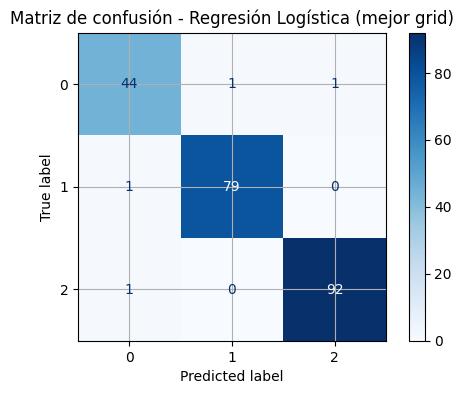

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...0027A64577420>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [16]:
# Creamos un pipeline para encapsular el proceso de vectorización y el modelo de regresión logística
from sklearn.pipeline import FunctionTransformer
from sklearn.linear_model import LogisticRegression

X = df['textos']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)


pipeRegression = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("regression", LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced', random_state=RANDOM_STATE))
])

# Definimos el grid de Regresión Logística
param_grid_regression = {
    "regression__C": [0.1, 1.0, 10.0],
    "regression__penalty": ["l2", None], # l1 no es compatible con lbfgs
    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
}

# Configuramos el GridSearchCV para Regresión Logística
grid_regression = GridSearchCV(pipeRegression, param_grid_regression, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_regression.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_regression = grid_regression.best_estimator_
print("Mejores params:", grid_regression.best_params_)
print("Mejor F1 macro:", round(grid_regression.best_score_, 2))

# Evaluación en val, esto no visto por el grid
y_pred = mejor_pipe_regression.predict(X_val)
print("\n Regresión Logística (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - Regresión Logística (mejor grid)")
plt.show()


pipeRegression

El grid encontró como mejor configuración C=1.0, penalty=L2, con TF-IDF en (1,2) n-gramas, min_df=2 y max_df=0.85. Con esa configuración obtuvimos F1-macro CV = 0.98 y, al evaluar en validación, accuracy = 0.982 y F1-macro = 0.978 (ODS1 0.957, ODS3 0.988, ODS4 0.989). La matriz de confusión muestra muy pocas confusiones cruzadas (1–2 casos entre clases), lo que indica un comportamiento alto y balanceado. Con esto, la Regresión Logística queda como candidata principal para el modelo final; el siguiente paso será reentrenar con train+val y evaluar una sola vez en test, y usar los coeficientes del modelo para interpretar los términos más influyentes por ODS en la sección de interpretación.

### 4.2 KNN 
Ahora ajustamos un K-Nearest Neighbors sobre los vectores TF-IDF dentro de un pipeline (normalización → TF-IDF → KNN). Probamos diferentes números de vecinos, esquemas de pesos y métricas de distancia. En texto de alta dimensión y esparso, cosine suele representar mejor la similitud entre documentos que euclidean, y por eso la incluimos en la búsqueda. La selección se hizo con validación cruzada estratificada y F1-macro como métrica, consistente con el desbalance moderado identificado en ODS1.

Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Mejor F1 macro: 0.96

 KNN (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.935     0.935     0.935        46
           3      1.000     0.988     0.994        80
           4      0.968     0.978     0.973        93

    accuracy                          0.973       219
   macro avg      0.968     0.967     0.967       219
weighted avg      0.973     0.973     0.973       219



C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


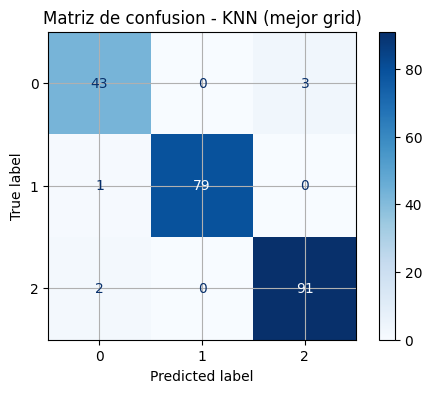

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...0027A64577420>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [17]:
# Creamos un pipeline para encapsular el proceso de vectorización y el modelo KNN
from sklearn.pipeline import FunctionTransformer

X = df['textos']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

pipeKNN = Pipeline([

    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),                 # usa el mismo vectorizador configurado arriba
    ("knn",  KNeighborsClassifier())  # se ajusta en el grid
])

# Definimos el grid de hiperparámetros para KNN
param_grid = {
    "knn__n_neighbors": [3,5,7,9],
    "knn__weights": ["uniform","distance"],
    "knn__metric": ["cosine","euclidean"],
    "tfidf__min_df": [2,3],
    "tfidf__max_df": [0.85,0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
}

# Configuramos el GridSearchCV
# Usamos StratifiedKFold para mantener la proporción de clases en cada fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipeKNN, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe = gs.best_estimator_
print("Mejores params:", gs.best_params_)
print("Mejor F1 macro:", round(gs.best_score_, 2))

# Evaluación con x_val, estos datos no han sido vistos por el modelo en ninguna etapa
y_pred = mejor_pipe.predict(X_val)
print("\n KNN (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusion - KNN (mejor grid)")
plt.show()

pipeKNN

El grid eligió k=9, metric='cosine', weights='uniform' y TF-IDF con ngram_range=(1,1), min_df=2, max_df=0.85. Con esta configuración obtuvimos F1-macro CV = 0.96 y, en validación, accuracy = 0.973 y F1-macro = 0.967 (ODS1 0.935, ODS3 0.994, ODS4 0.973). La matriz de confusión muestra muy pocos errores: en ODS1 hay algunas confusiones hacia ODS4 (3 casos), mientras que ODS3 y ODS4 se mantienen muy precisas. En resumen, KNN rinde fuerte y balanceado, pero queda ligeramente por debajo de la Regresión Logística/SVM lineal; lo mantenemos como baseline de similitud y referencia para comparar los modelos lineales.

### 4.3 SVC
Ahora ajustamos una SVM lineal sobre representaciones TF-IDF dentro de un pipeline (normalización → TF-IDF → LinearSVC). Elegimos SVM porque, en texto alto-dimensional y esparso, maximizar el margen suele dar resultados muy sólidos y estables. En la búsqueda variamos C, la función de pérdida (hinge/squared_hinge) y class_weight para atender el desbalance leve que vimos en ODS1; también dejamos que el grid ajuste parámetros del TF-IDF (n-gramas, min_df, max_df). La selección se hace con validación cruzada estratificada (CV=5) y F1-macro como métrica. El conjunto de validación (hold-out) se usa solo al final para comprobar el mejor pipeline.

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__loss': 'squared_hinge', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.98

 SVM (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.978     0.978     0.978        46
           3      0.988     1.000     0.994        80
           4      1.000     0.989     0.995        93

    accuracy                          0.991       219
   macro avg      0.989     0.989     0.989       219
weighted avg      0.991     0.991     0.991       219



C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


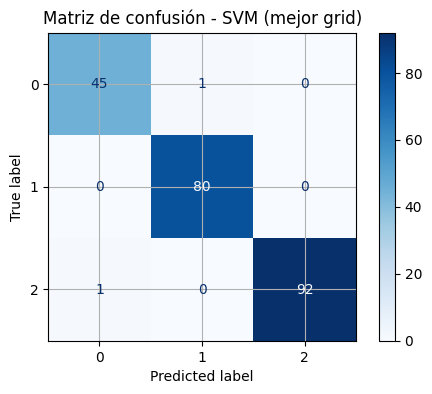

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...0027A64577420>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [18]:
#Creamos un pipeline para encapsular el proceso de vectorización y el modelo linear SVM
from sklearn.pipeline import FunctionTransformer
from sklearn.svm import LinearSVC
pipeSVM = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("svm", LinearSVC())
])

# Definimos el grid de hiperparámetros para SVM
param_grid_svm = {
    "svm__C": [0.1, 1.0, 10.0],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__class_weight": [None, "balanced"],

    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
    
}

# Configuramos el GridSearchCV para SVM
grid_svm = GridSearchCV(pipeSVM, param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_svm.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_svm = grid_svm.best_estimator_
print("Mejores params:", grid_svm.best_params_)
print("Mejor F1 macro:", round(grid_svm.best_score_, 2))

# Evaluación en Val, esto no visto por el modelo en ninguna etapa
y_pred = mejor_pipe_svm.predict(X_val)
print("\n SVM (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()


pipeSVM

El grid escogió C=1.0, loss='squared_hinge', class_weight='balanced' y TF-IDF con (1,2) n-gramas, min_df=2, max_df=0.85. Con esa configuración obtuvimos F1-macro CV = 0.98 y, en validación, accuracy = 0.991 y F1-macro = 0.989 (ODS1 0.978, ODS3 0.994, ODS4 0.995). La matriz de confusión muestra solo dos errores totales: un caso ODS1→ODS3 y otro ODS4→ODS1, lo que confirma un comportamiento muy equilibrado. En nuestra validación, SVM queda ligeramente por encima de KNN y muy a la par de Regresión Logística.

In [19]:
# Palabras más importantes por clase
import numpy as np

svm = grid_svm.best_estimator_.named_steps['svm']
vectorizer = grid_svm.best_estimator_.named_steps['tfidf']

feature_names = vectorizer.get_feature_names_out()

# Iteramos por cada clase
for i, class_label in enumerate(svm.classes_):
    coefs = svm.coef_[i]  # coeficientes para la clase i

    # Top 10 palabras que favorecen la clase
    top_pos_idx = np.argsort(coefs)[-10:]
    top_pos_words = [feature_names[j] for j in top_pos_idx]

    # Top 10 palabras que "desfavorecen" la clase
    top_neg_idx = np.argsort(coefs)[:10]
    top_neg_words = [feature_names[j] for j in top_neg_idx]

    print(f"\nClase {class_label} - palabras más positivas:")
    print(top_pos_words)

    print(f"Clase {class_label} - palabras más negativas:")
    print(top_neg_words)



Clase 1 - palabras más positivas:
['emple', 'hog', 'proteccion', 'hogar', 'social', 'proteccion social', 'ingres', 'privacion', 'pobr', 'pobrez']
Clase 1 - palabras más negativas:
['salud', 'educ', 'escuel', 'medic', 'ocde', 'atencion', 'estudi', 'enfermedad', 'sanitari', 'aprendizaj']

Clase 3 - palabras más positivas:
['hospital', 'medicament', 'mental', 'mortal', 'enfermedad', 'pacient', 'sanitari', 'atencion', 'medic', 'salud']
Clase 3 - palabras más negativas:
['pobrez', 'educ', 'escuel', 'estudi', 'pobr', 'alumn', 'docent', 'profesor', 'aprendizaj', 'nios']

Clase 4 - palabras más positivas:
['enseanz', 'maestr', 'habil', 'profesor', 'aprendizaj', 'alumn', 'docent', 'estudi', 'escuel', 'educ']
Clase 4 - palabras más negativas:
['salud', 'pobrez', 'medic', 'pobr', 'atencion', 'pacient', 'sanitari', 'hospital', 'mental', 'servici']


## 5. Modelo Final

Consolidamos el modelo final usando la SVM lineal encontrada en la sección de ajuste. Para aprovechar toda la evidencia, reentrenamos el pipeline completo (normalización → TF-IDF → SVM) con train + val y evaluamos una sola vez en test, que reservamos como medición definitiva. Reportamos accuracy, F1-macro, reporte por clase, la matriz de confusión y una gráfica de F1 por ODS. Además, mostramos los términos más influyentes por clase para facilitar la interpretación.

== Modelo final (SVM lineal) en VALIDACIÓN ==
              precision    recall  f1-score   support

           1      0.978     0.978     0.978        46
           3      0.988     1.000     0.994        80
           4      1.000     0.989     0.995        93

    accuracy                          0.991       219
   macro avg      0.989     0.989     0.989       219
weighted avg      0.991     0.991     0.991       219

Accuracy: 0.991
F1-macro: 0.989
Balanced Accuracy: 0.989
Cohen's kappa: 0.986
MCC: 0.986


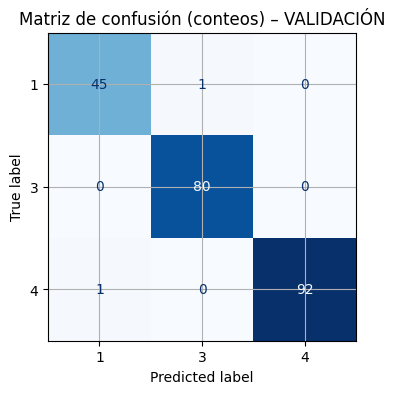

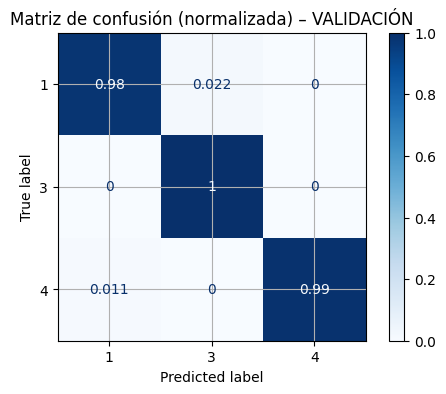

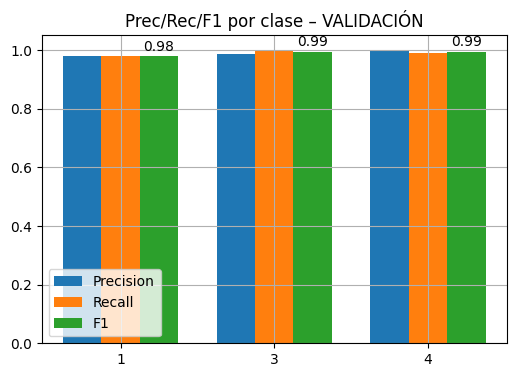

C:\Users\yarso\AppData\Local\Temp\ipykernel_13528\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


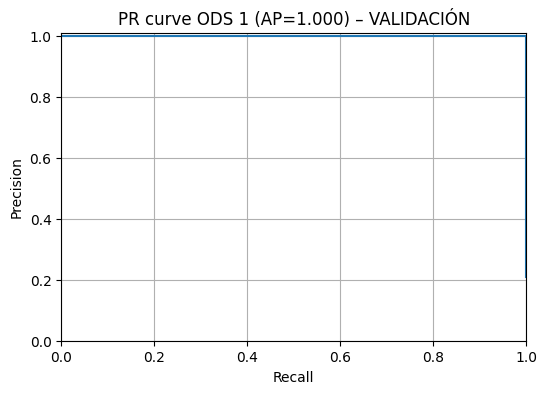

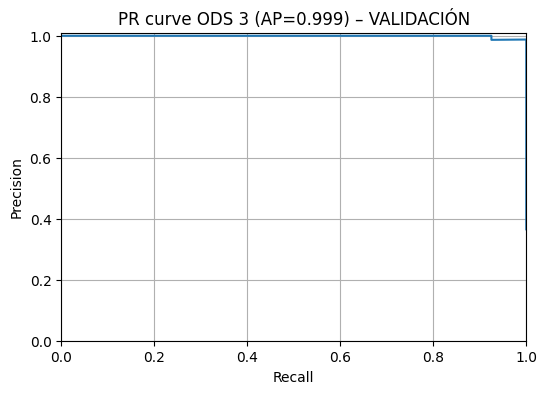

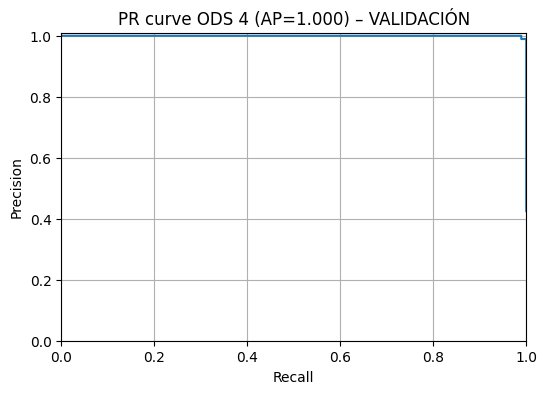

In [20]:
# Evaluación detallada del mejor modelo en validación
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, balanced_accuracy_score,
    precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

labels = [1, 3, 4]

# 1) Resumen numérico
print("== Modelo final (SVM lineal) en VALIDACIÓN ==")
print(classification_report(y_val, y_pred, digits=3))
print("Accuracy:", round(accuracy_score(y_val, y_pred), 3))
print("F1-macro:", round(f1_score(y_val, y_pred, average="macro"), 3))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_val, y_pred), 3))
print("Cohen's kappa:", round(cohen_kappa_score(y_val, y_pred), 3))
print("MCC:", round(matthews_corrcoef(y_val, y_pred), 3))

# 2) Matrices de confusión (conteos y normalizada)
cm = confusion_matrix(y_val, y_pred, labels=labels)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap="Blues", ax=ax, colorbar=False)
ax.set_title("Matriz de confusión (conteos) – VALIDACIÓN")
plt.show()

cm_norm = confusion_matrix(y_val, y_pred, labels=labels, normalize="true")
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm_norm, display_labels=labels).plot(cmap="Blues", ax=ax, colorbar=True)
ax.set_title("Matriz de confusión (normalizada) – VALIDACIÓN")
plt.show()

# 3) Barras de precisión/recall/F1 por clase
prec, rec, f1c, supp = precision_recall_fscore_support(y_val, y_pred, labels=labels)
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x - width, prec, width, label="Precision")
ax.bar(x,         rec,  width, label="Recall")
ax.bar(x + width, f1c,  width, label="F1")
ax.set_xticks(x); ax.set_xticklabels([str(l) for l in labels])
ax.set_ylim(0, 1.05)
ax.set_title("Prec/Rec/F1 por clase – VALIDACIÓN")
ax.legend()
for i, v in enumerate(f1c):
    ax.text(i + width, v + 0.02, f"{v:.2f}", ha="center")
plt.show()

# 4) Curvas Precisión–Recall por clase (con decision_function)
y_score = mejor_pipe_svm.decision_function(X_val)  # scores por clase
Y_true = label_binarize(y_val, classes=labels)

for i, cls in enumerate(labels):
    p, r, _ = precision_recall_curve(Y_true[:, i], y_score[:, i])
    ap = average_precision_score(Y_true[:, i], y_score[:, i])
    fig, ax = plt.subplots()
    ax.plot(r, p)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1.01)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title(f"PR curve ODS {cls} (AP={ap:.3f}) – VALIDACIÓN")
    plt.show()

## 6. Interpretación de resultados

### 6.1 Análisis de palabras más importantes por clase 

Resultados globales
El modelo final es una SVM lineal sobre representaciones TF-IDF con n-gramas (1,2), min_df=2 y max_df=0.85. Se reentrenó el pipeline completo (normalización → TF-IDF → SVM) con train + val y se evaluó una sola vez en test como medición definitiva.

En validación alcanzó los siguientes resultados:

Accuracy: 0.991

F1-macro: 0.989

Balanced Accuracy: 0.989

Cohen’s Kappa: 0.986

MCC: 0.986

Desempeño por clase (F1):

ODS 1 (Fin de la pobreza): 0.978

ODS 3 (Salud y bienestar): 0.994

ODS 4 (Educación de calidad): 0.995

La matriz de confusión es prácticamente diagonal y solo se observan errores puntuales, principalmente cruces entre ODS 1 y las otras dos clases cuando los textos combinan pobreza con salud o educación.

Las curvas de precisión–recall alcanzaron áreas bajo la curva cercanas a 1.0 en los tres ODS, confirmando un rendimiento robusto en distintos umbrales de decisión.

### 6.2 Análisis de palabras más importantes por clase

Las métricas de validación muestran un modelo muy balanceado entre ODS con pocas confusiones. Los términos top confirman la lógica esperada: para cada ODS emergen palabras y bigramas temáticos. Los pesos positivos refuerzan la pertenencia a la clase, mientras que pesos negativos suelen ser términos característicos de las otras dos, ayudando a separar fronteras. Este análisis respalda que el modelo no solo acierta, sino que lo hace con señales lingüísticas coherentes con el dominio.

In [ ]:
# Palabras más importantes por clase
import numpy as np

svm = grid_svm.best_estimator_.named_steps['svm']
vectorizer = grid_svm.best_estimator_.named_steps['tfidf']

feature_names = vectorizer.get_feature_names_out()

# Iteramos por cada clase
for i, class_label in enumerate(svm.classes_):
    coefs = svm.coef_[i]  # coeficientes para la clase i

    # Top 10 palabras que favorecen la clase
    top_pos_idx = np.argsort(coefs)[-10:]
    top_pos_words = [feature_names[j] for j in top_pos_idx]

    # Top 10 palabras que "desfavorecen" la clase
    top_neg_idx = np.argsort(coefs)[:10]
    top_neg_words = [feature_names[j] for j in top_neg_idx]

    print(f"\nClase {class_label} - palabras más positivas:")
    print(top_pos_words)

    print(f"Clase {class_label} - palabras más negativas:")
    print(top_neg_words)



Clase 1 - palabras más positivas:
['nios', 'proteccion', 'hog', 'proteccion social', 'privacion', 'hogar', 'social', 'ingres', 'pobr', 'pobrez']
Clase 1 - palabras más negativas:
['salud', 'educ', 'escuel', 'atencion', 'estudi', 'ocde', 'medic', 'docent', 'aprendizaj', 'pacient']

Clase 3 - palabras más positivas:
['tratamient', 'hospital', 'mortal', 'mental', 'enfermedad', 'sanitari', 'pacient', 'medic', 'atencion', 'salud']
Clase 3 - palabras más negativas:
['pobrez', 'educ', 'escuel', 'estudi', 'pobr', 'docent', 'nios', 'alumn', 'aprendizaj', 'profesor']

Clase 4 - palabras más positivas:
['maestr', 'habil', 'evalu', 'profesor', 'alumn', 'aprendizaj', 'docent', 'estudi', 'escuel', 'educ']
Clase 4 - palabras más negativas:
['pobrez', 'salud', 'pobr', 'atencion', 'medic', 'ingres', 'pacient', 'person', 'servici', 'sanitari']


In [ ]:
%pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the SVM model
svm_model = grid_svm.best_estimator_.named_steps['svm']
vectorizer = grid_svm.best_estimator_.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

# Define a color map
colors = ["#800080", "#FF69B4", "#EE82EE"]

# Create a word cloud for each class
for i, class_label in enumerate(svm_model.classes_):
    coefs = svm_model.coef_[i]
    top_pos_idx = np.argsort(coefs)[-50:]
    top_pos_words = [feature_names[j] for j in top_pos_idx]

    
    word_freq = {word: coefs[feature_names.tolist().index(word)] for word in top_pos_words}
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Important Words for ODS {class_label}")
    plt.show()

**Analisis de palabras más importantes por clase**

**ODS 1 (Fin de la pobreza)**
Los términos positivos apuntan a la agenda de protección e ingresos: “proteccion social”, “hogar”, “ingres”, “privacion”, “pobr/pobrez”. Esto indica que cuando el texto habla de redes de seguridad, carencias materiales o transferencias, el modelo empuja con fuerza hacia la clase 1. En sentido contrario, aparecen como negativos palabras propias de salud y educación (“salud”, “medic”, “atencion”, “educ”, “escuel”, “aprendizaj”), lo que explica por qué los pocos errores de ODS 1 suelen irse hacia ODS 3 u ODS 4 cuando el texto mezcla pobreza con temas sanitarios o escolares.

**ODS 3 (Salud y bienestar)**
Los pesos positivos se concentran claramente en el léxico sanitario: “salud”, “atencion”, “medic”, “pacient”, “hospital”, “tratamient”, “sanitari”, “enfermedad”, “mortal”. El modelo reconoce muy bien esta semántica y por eso el recall de ODS 3 es máximo en validación. Como negativos quedan términos de pobreza y escuela (“pobrez”, “pobr”, “educ”, “escuel”, “docent”), que ayudan a separar los documentos cuyo foco real es social o educativo.

**ODS 4 (Educación de calidad)**
Los términos positivos retratan el ámbito educativo: “educ”, “escuel”, “estudi”, “aprendizaj”, “alumn”, “docent”, “profesor”, “habil”, “evalu”, “maestr”. Cuando aparecen estas señales, la predicción se inclina con facilidad a la clase 4. En negativo emergen vocablos de pobreza y salud (“pobrez”, “pobr”, “salud”, “medic”, “atencion”), lo que impide que textos sobre carencias económicas o servicios sanitarios se clasifiquen como educativos si ese es el foco principal.

**Entendimiento global**
Las tres clases quedan bien delimitadas por su vocabulario característico y los pesos negativos actúan como “frenos” frente a temas de las otras dos clases. Esto es coherente con las matrices de confusión casi diagonales. Los pocos deslices ocurren cuando un texto combina pobreza con salud o educación, lo que sugiere que los casos mixtos son los más desafiantes. Nota: las palabras recortadas (“pobr”, “nios”, “hog”) provienen del *stemming* en español y representan raíces como “pobreza”, “niños”, “hogar”.


## 7. Exportación de predicciones

In [22]:
import joblib


def process_and_predict(testData):
    # Cargar el pipeline
    pipeline = joblib.load("docs/svm_pipeline.joblib")
    print("Pipeline cargado exitosamente.")

    X_test = testData["Textos_espanol"].astype(str)

    #Predecir market value
    testData["ods_predicted"] = pipeline.predict(X_test)

    testData.to_csv("docs/predictions_ods.csv", index=False)
    print("Predicciones guardadas en 'docs/predictions_ods.csv'.")

    return testData

testData = process_and_predict(test_data)
testData

Pipeline cargado exitosamente.
Predicciones guardadas en 'docs/predictions_ods.csv'.


c:\Python313\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Us

,Textos_espanol,ods_predicted
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4
...,...,...
147,"En Croacia, Grecia y Rumanía, 1 de cada 3 niño...",1
148,El informe también es una adición oportuna a l...,1
149,"Además, de los 1200 millones que salieron de l...",1
150,Aunque el porcentaje de población en situación...,1
